In [1]:
import h5py
import pyBigWig
import matplotlib
from tqdm import tqdm
import scipy.ndimage
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import math
import pandas as pd
import json 

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

In [2]:
file1= "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/uncorrected_model_09.23.2024_filters_512_dil_8_fold_fold_0/uncorrected_model/hint_atac_predictions.h5" 
bigwig="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/data/K562_unstranded.bw"
peaks="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/uncorrected_model_09.23.2024_filters_512_dil_8_fold_fold_0/uncorrected_model/filtered.peaks.bed"
nonpeaks="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/uncorrected_model_09.23.2024_filters_512_dil_8_fold_fold_0/uncorrected_model/filtered.nonpeaks.bed"

chr_fold_path="/mnt/lab_data2/anusri/chrombpnet/splits/fold_0.json"
outf="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/uncorrected_model_09.23.2024_filters_512_dil_8_fold_fold_0/uncorrected_model/"


# Plotting

In [3]:
def density_scatter(x, y, xlab, ylab, ax = None, sort = True, bins = 20):
    """
    Scatter plot colored by 2d histogram
    """
    bad_indices=np.where(np.isnan(x))+np.where(np.isnan(y))
    x=x[~np.isin(np.arange(x.size),bad_indices)]
    y=y[~np.isin(np.arange(y.size),bad_indices)]

    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0
    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    #z = [plt.cm.viridis(t) for t in z]
    ax.scatter( x, y, c=z ,linewidths=0,edgecolors=None, rasterized=True)
    #ax.plot(x,y,'o',rasterized=True,linewidths=0,c=z)

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    return ax

# Main

In [4]:
data = h5py.File(file1)

mode="test"
splits_dict=json.load(open(chr_fold_path))
chroms_to_keep=splits_dict[mode]

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
peaks_bed_regions=pd.read_csv(peaks,header=None,sep='\t',names=NARROWPEAK_SCHEMA)
peaks_bed_regions_to_keep=peaks_bed_regions[peaks_bed_regions["chr"].isin(chroms_to_keep)]

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
nonpeaks_bed_regions=pd.read_csv(nonpeaks,header=None,sep='\t',names=NARROWPEAK_SCHEMA)
nonpeaks_bed_regions_to_keep=nonpeaks_bed_regions[nonpeaks_bed_regions["chr"].isin(chroms_to_keep)]


profile_predictions = data["predictions"]["logcounts"].value
prof_coords_chr = data["coords"]["coords_chrom"].value
prof_coords_center = data["coords"]["coords_center"].value
prof_coords_peak = data["coords"]["coords_peak"].value


/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  app.launch_new_instance()
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/users/a

In [5]:
bw = pyBigWig.open(bigwig) 

true_counts_mat_peaks = []
true_counts_mat_peaks_non_peaks = []

idx=0
for jdx in tqdm(range(prof_coords_chr.shape[0])):
        if prof_coords_peak[jdx] == 0:
                chr1 = nonpeaks_bed_regions_to_keep.iloc[idx, 0]
                start = nonpeaks_bed_regions_to_keep.iloc[idx, 1] + nonpeaks_bed_regions_to_keep.iloc[idx, -1] - 500
                end  =  nonpeaks_bed_regions_to_keep.iloc[idx, 1] + nonpeaks_bed_regions_to_keep.iloc[idx, -1] + 500

                true_counts = np.nan_to_num(bw.values(chr1,start,end ))
                true_counts_mat_peaks_non_peaks.append(np.log(np.sum(true_counts)+1))
                
                idx += 1
                continue

        chr1 = peaks_bed_regions_to_keep.iloc[jdx, 0]
        start = peaks_bed_regions_to_keep.iloc[jdx, 1] + peaks_bed_regions_to_keep.iloc[jdx, -1] - 500
        end  =  peaks_bed_regions_to_keep.iloc[jdx, 1] + peaks_bed_regions_to_keep.iloc[jdx, -1] + 500

        true_counts = np.nan_to_num(bw.values(chr1,start,end ))
        true_counts_mat_peaks.append(np.log(np.sum(true_counts)+1))
        true_counts_mat_peaks_non_peaks.append(np.log(np.sum(true_counts)+1))
        

100%|██████████| 66474/66474 [00:31<00:00, 2094.82it/s]


In [8]:
import scipy.stats
cta = scipy.stats.pearsonr(true_counts_mat_peaks,profile_predictions[prof_coords_peak==1])
print(cta)

(0.7026259334955779, 0.0)


<Figure size 576x576 with 0 Axes>

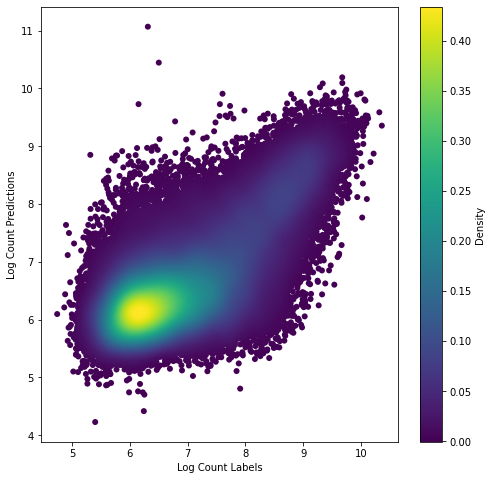

In [72]:
plt.rcParams["figure.figsize"]=8,8
fig=plt.figure() 
density_scatter(np.array(true_counts_mat_peaks),
                profile_predictions[prof_coords_peak==1],
                xlab='Log Count Labels',
                ylab='Log Count Predictions')

#plt.savefig(outf + "/K562.uncorrected.scatter.plot.peaks.pdf",format='pdf',dpi=300, transparent=True)
# plt.savefig("subfigs/performance_plots/K562.scatter.plot.peaks.pdf",format='pdf',dpi=300, transparent=True)
plt.savefig("K562.uncorrected.scatter.plot.peaks.pdf",format='pdf',dpi=300, transparent=True)


<AxesSubplot:xlabel='Log Count Labels', ylabel='Log Count Predictions'>

<Figure size 576x576 with 0 Axes>

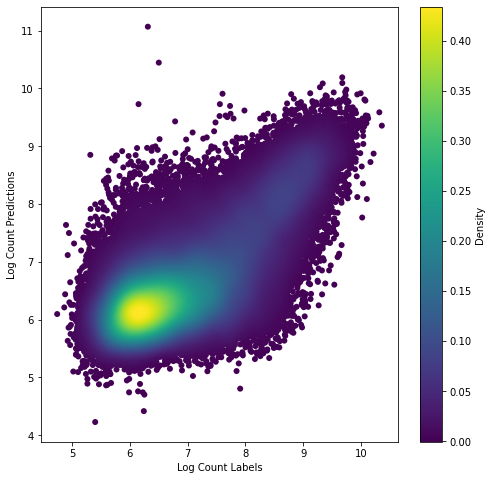

In [10]:
plt.rcParams["figure.figsize"]=8,8
fig=plt.figure() 
density_scatter(np.array(true_counts_mat_peaks_non_peaks),
                profile_predictions,
                xlab='Log Count Labels',
                ylab='Log Count Predictions')

#plt.savefig(outf + "/K562.scatter.plot.peaks.nonpeaks.pdf",format='pdf',dpi=300, transparent=True)
# plt.savefig("subfigs/performance_plots/K562.scatter.plot.peaks.nonpeaks.pdf",format='pdf',dpi=300, transparent=True)
#plt.savefig(outf + "K562.uncorrectedscatter.plot.peaks.nonpeaks.pdf",format='pdf',dpi=300, transparent=True)


In [73]:
data=pd.read_csv("/mnt/lab_data2/anusri/chrombpnet/k562_dnase_uncorrected.csv",sep=",", names=["fold", "model"])
import json

In [74]:
pearsonr=[]

In [75]:
for i,r in data.iterrows():
    metrics = json.load(open(r["model"].replace("hint_atac.h5", "hint_atac_metrics.json")))
    pearsonr.append(metrics['counts_metrics']['peaks']['pearsonr'])

In [76]:
np.round(np.mean(pearsonr),2)

0.71

In [77]:
pearsonr

[0.7111061714793029,
 0.703355103181614,
 0.698906417209249,
 0.710244344407988,
 0.701607319873831]

In [78]:
np.round(np.std(pearsonr),2)


0.0

In [79]:
np.std(pearsonr)

0.004819264885630181